In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import scipy.stats as stats
import os
from IPython.display import HTML, display
import calendar
from datetime import datetime
import collections
import json

sns.set_style('darkgrid')
sns.set(font_scale=1.5)

# Data Loading

In [25]:
videos_df = pd.read_pickle('US_trending.pkl')

# filtriranje datuma do 1.4.2020. (korona)
videos_df = videos_df[videos_df['trending_date'] < datetime(2020, 4, 1)]

In [26]:
videos_df.head()

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,...,days_in_trending,category_name,publish_to_trend,publishing_hour,publishing_day,disc_likes,positive_sentiment,negative_sentiment,neutral_sentiment,analyzed_comments
0,vPx6M7eTYbc,Spill Your Guts: Harry Styles & Kendall Jenner,2019-12-11 07:08:34,UCJ0uqCI0Vqr2Rrt1HseGirg,The Late Late Show with James Corden,24,2019-12-12,The Late Late Show|Late Late Show|James Corden...,11636632,571835,...,1,Entertainment,1,7,Wednesday,3.0,0.468750,0.131250,0.400000,160.0
1,sg8WaeeFyNY,WE GOT UNEXPECTED NEWS..,2019-12-12 05:25:42,UCDSJCBYqL7VQrlXfhr1RtwA,Les Do Makeup,26,2019-12-12,[none],423215,52780,...,7,How-to & Style,0,5,Thursday,3.0,0.750000,0.075000,0.175000,40.0
2,q1PR05q8l2g,"Last To Miss Layup Wins $10,000",2019-12-11 23:00:53,UCQIUhhcmXsu6cN6n3y9-Pww,Jesser,17,2019-12-12,last to leave|nba basketball|nba basketball hi...,463685,20178,...,7,Sport,1,23,Wednesday,2.0,0.318182,0.181818,0.500000,88.0
3,t6Z6RIXq0L0,LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...,2019-12-12 02:35:33,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,17,2019-12-12,sp:ty=high|sp:dt=2019-12-12T00:00:00Z|sp:st=ba...,659579,4605,...,2,Sport,0,2,Thursday,1.0,0.462069,0.193103,0.344828,145.0
4,TGDpRB4ovvA,TIPPING DRIVE-THRU WORKERS $100 FOR THE HOLIDA...,2019-12-12 02:38:37,UCtj45MepAoKxZoyR_Mnt86Q,Royal Family,24,2019-12-12,queen Naija|Medicine|Queen|Spicy|Royalty Squad...,175558,18400,...,6,Entertainment,0,2,Thursday,2.0,0.631250,0.131250,0.237500,160.0


# Exploratory Data Analysis

### Top 15 most popular categories by number of videos in trending

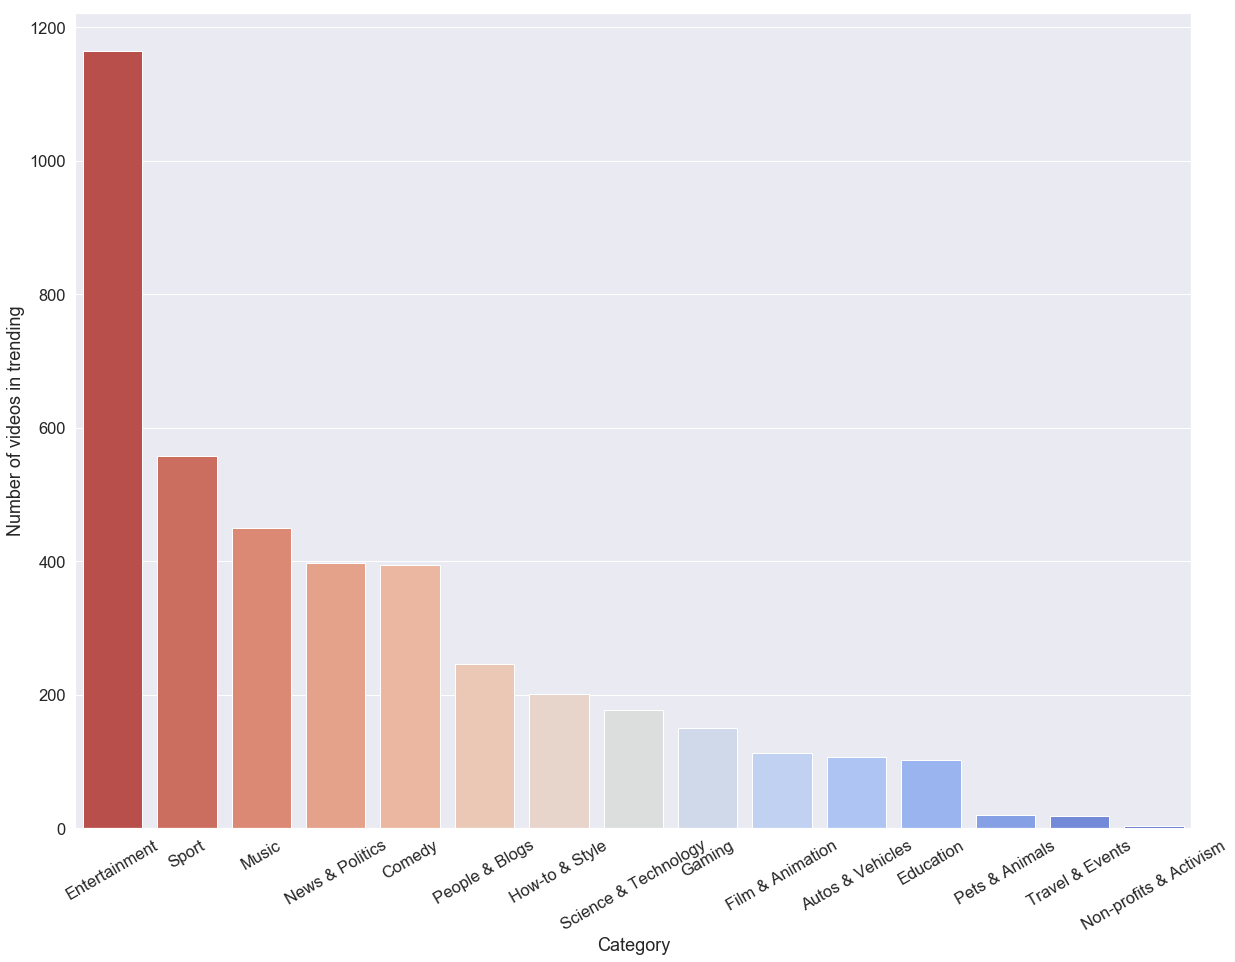

In [27]:
# Most popular categories by number of videos in trending
fig, ax = plt.subplots(figsize=(20, 15))
sns.countplot(x='category_name', data=videos_df, order=videos_df['category_name'].value_counts().index, palette='coolwarm_r', ax=ax)
plt.xticks(rotation=30)
ax.set(xlabel='Category', ylabel='Number of videos in trending')

fig.savefig('plots/categories_videos_trending')

### Top 15 most popular channels by number of videos in trending

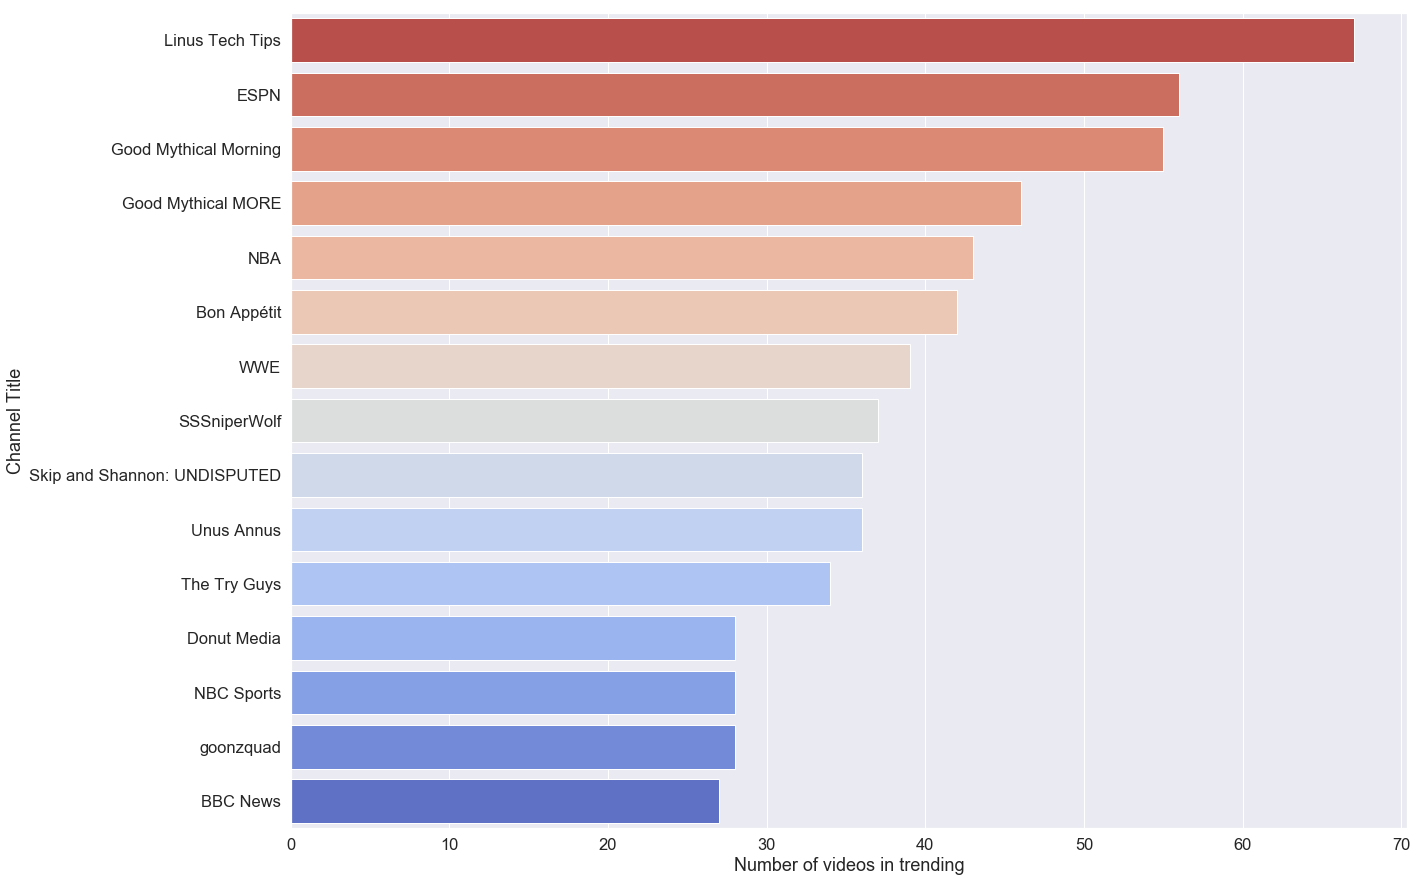

In [5]:
# Most popular channels by number of videos in trending
channel_trending_videos = videos_df.groupby('channel_title')[['video_id', 'channel_title']].count()
top_channels = channel_trending_videos.nlargest(15, 'video_id')

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=top_channels['channel_title'], y=top_channels.index, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Number of videos in trending', ylabel='Channel Title')

fig.savefig('plots/popular_channels_videos')

### Top 15 most popular channels by number of views

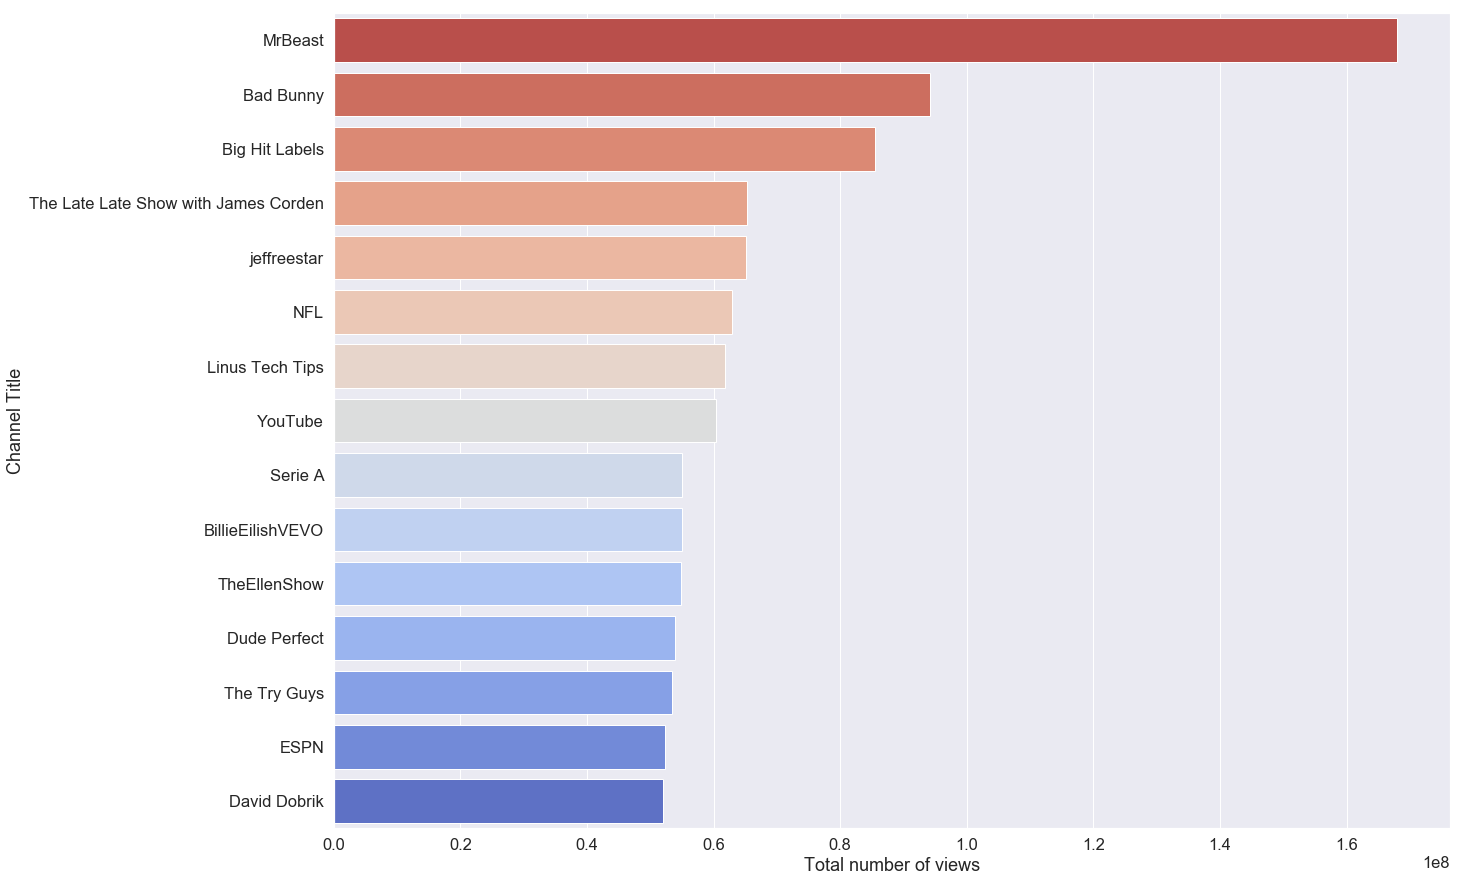

In [6]:
top_views_channels = videos_df.groupby('channel_title')[['view_count', 'channel_title']].sum()
top_viwes_channels = top_views_channels.nlargest(15, 'view_count')

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=top_viwes_channels['view_count'], y=top_viwes_channels.index, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Total number of views', ylabel='Channel Title')

fig.savefig('plots/popular_channels_views')

### Top 15 most popular channels by number of likes

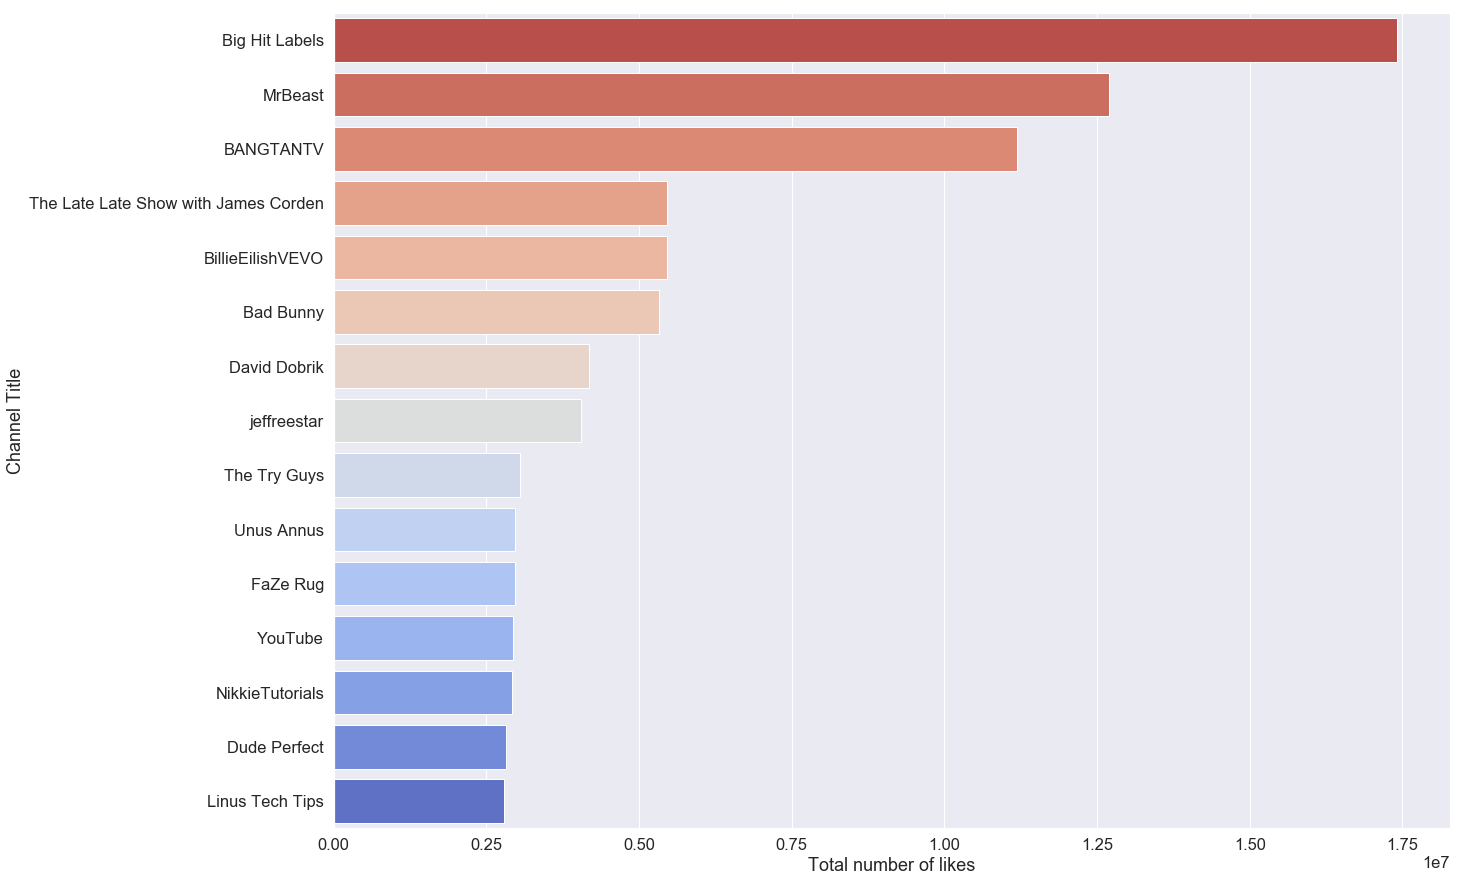

In [7]:
top_likes_channels = videos_df.groupby('channel_title')[['likes', 'channel_title']].sum()
top_likes_channels = top_likes_channels.nlargest(15, 'likes')

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=top_likes_channels['likes'], y=top_likes_channels.index, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Total number of likes', ylabel='Channel Title')

fig.savefig('plots/popular_channels_likes')

### Top 15 videos that were the longest in trending

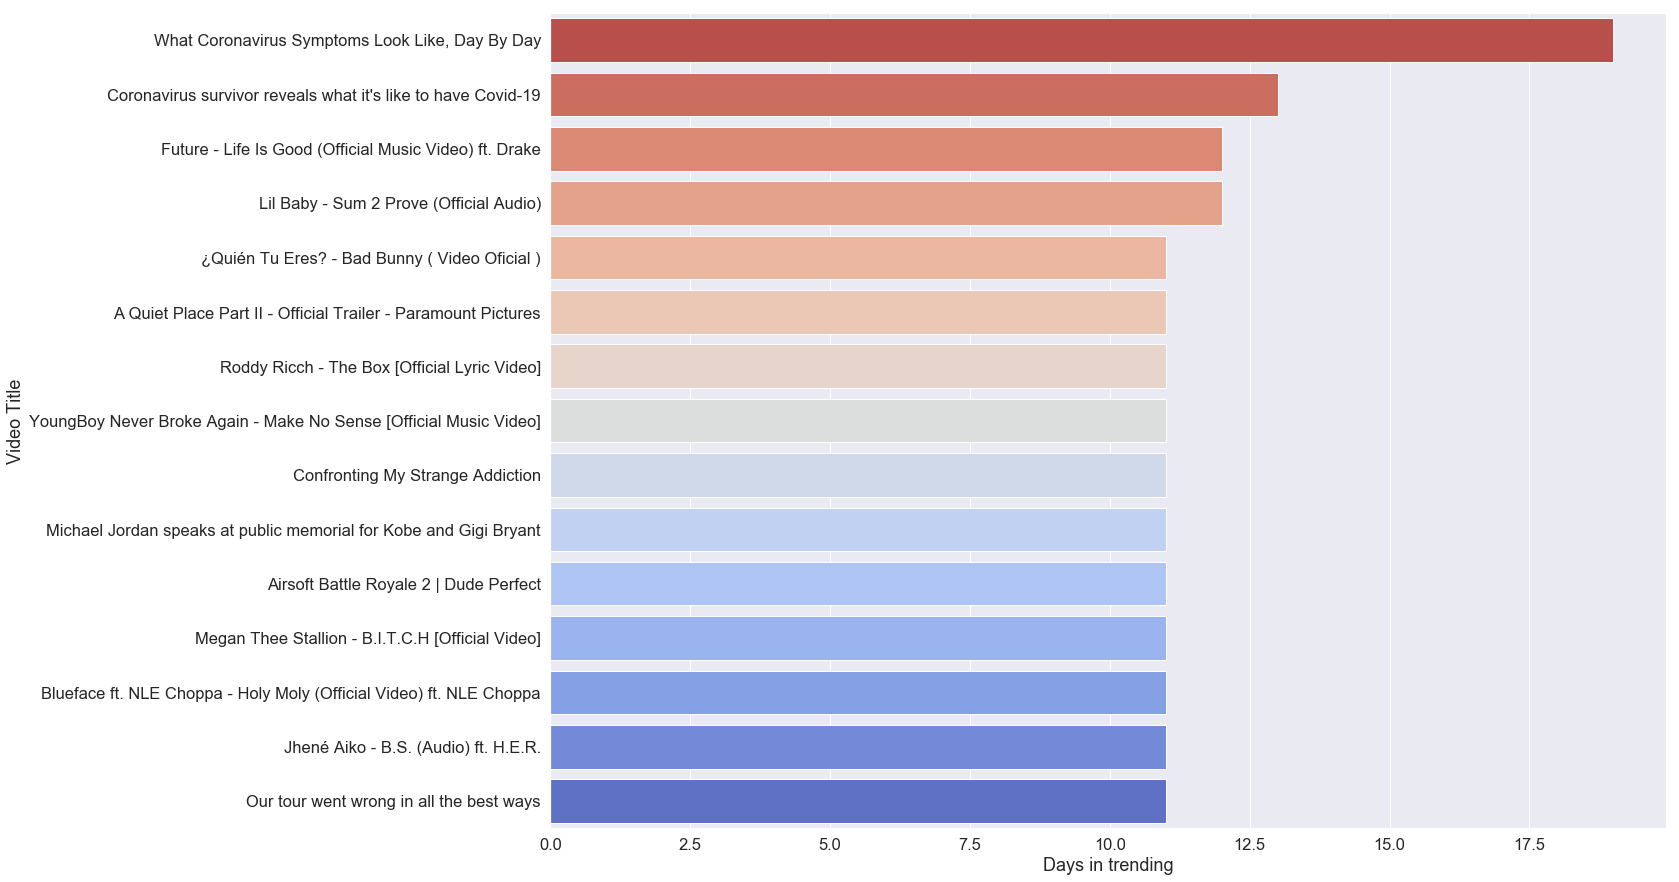

In [8]:
# top 15 videos that were the longest in trending
top_videos = videos_df.nlargest(15, 'days_in_trending')

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=top_videos['days_in_trending'], y=top_videos['title'], palette='coolwarm_r', ax=ax)
ax.set(xlabel='Days in trending', ylabel='Video Title')

fig.savefig('plots/videos_longest_trend')

[Text(0.5, 0, 'Days in trending')]

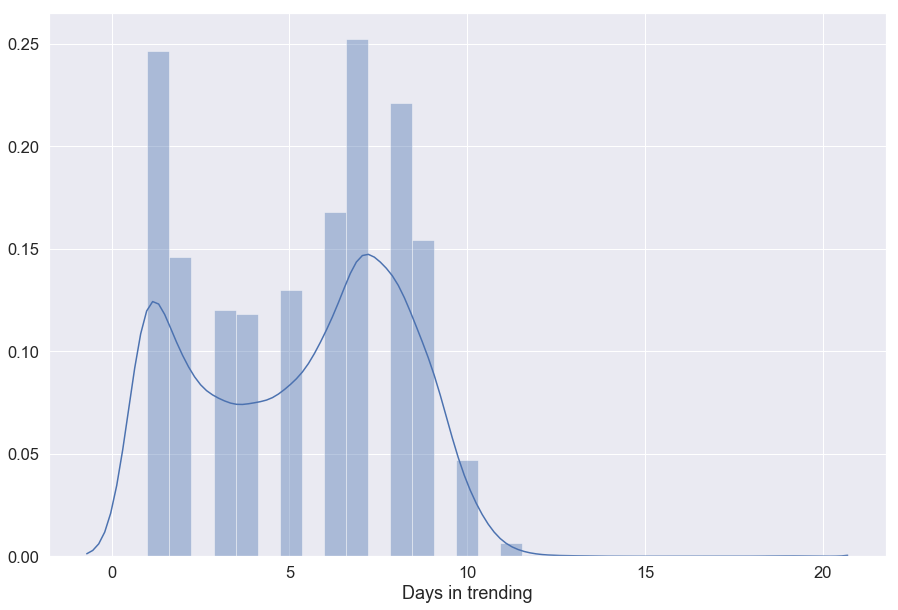

In [9]:
# distribution of days in trending
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(videos_df['days_in_trending'])
ax.set(xlabel='Days in trending')

### Average time in trending by category

"fig, ax = plt.subplots(figsize=(20, 15))\nax.bar(x=videos_df['category_name'].value_counts().index,\n        height=videos_df['category_name'].value_counts().values,\n        color=sns.color_palette('coolwarm_r', len(x)))\nplt.xticks(rotation=45)\nax.bar(x=videos_df['category_name'].value_counts().index, \n       height=avg_trend_duration_category['days_in_trending'],\n       color=sns.color_palette('coolwarm_r', len(x)))\nplt.xticks(rotation=45)"

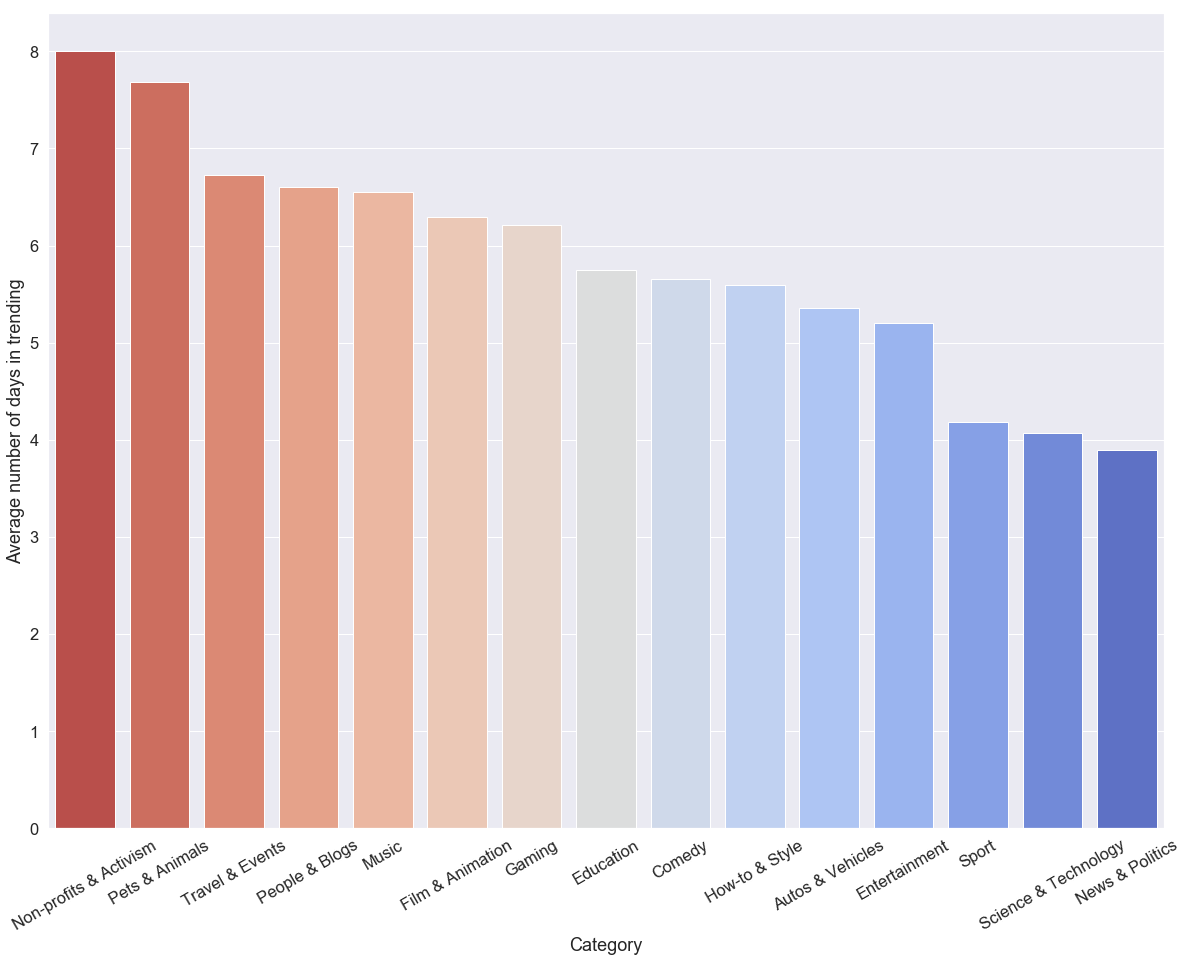

In [10]:
avg_trend_duration_category = videos_df.groupby('category_name')[['days_in_trending', 'category_name']].mean()
avg_trend_duration_category = avg_trend_duration_category.sort_values(by='days_in_trending', ascending=False)

#order=videos_df['category_name'].value_counts().index,

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=avg_trend_duration_category.index, y=avg_trend_duration_category['days_in_trending'], palette='coolwarm_r', ax=ax)
plt.xticks(rotation=30)
ax.set(xlabel='Category', ylabel='Average number of days in trending')

fig.savefig('plots/categories_time_trend')

"""fig, ax = plt.subplots(figsize=(20, 15))
ax.bar(x=videos_df['category_name'].value_counts().index,
        height=videos_df['category_name'].value_counts().values,
        color=sns.color_palette('coolwarm_r', len(x)))
plt.xticks(rotation=45)
ax.bar(x=videos_df['category_name'].value_counts().index, 
       height=avg_trend_duration_category['days_in_trending'],
       color=sns.color_palette('coolwarm_r', len(x)))
plt.xticks(rotation=45)"""

### Likes/Dislikes ratio by category

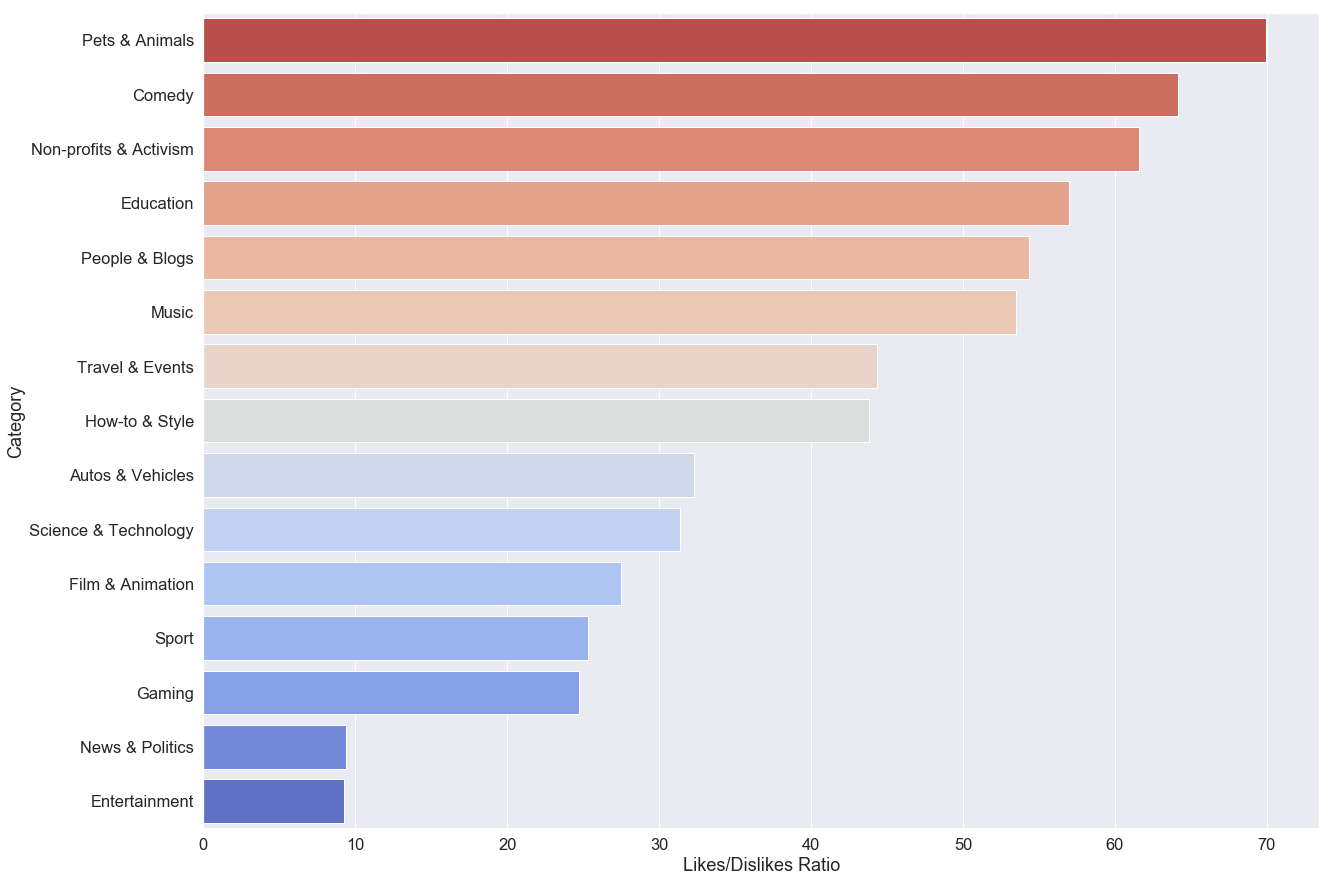

In [11]:
like_dislike_ratio = videos_df.groupby('category_name')['likes'].sum() / videos_df.groupby('category_name')['dislikes'].sum()
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['category','ratio']
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='ratio', y='category', data=like_dislike_ratio, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Likes/Dislikes Ratio', ylabel='Category')

fig.savefig('plots/like_dislike_ratio')

### Comments/Views ratio by category

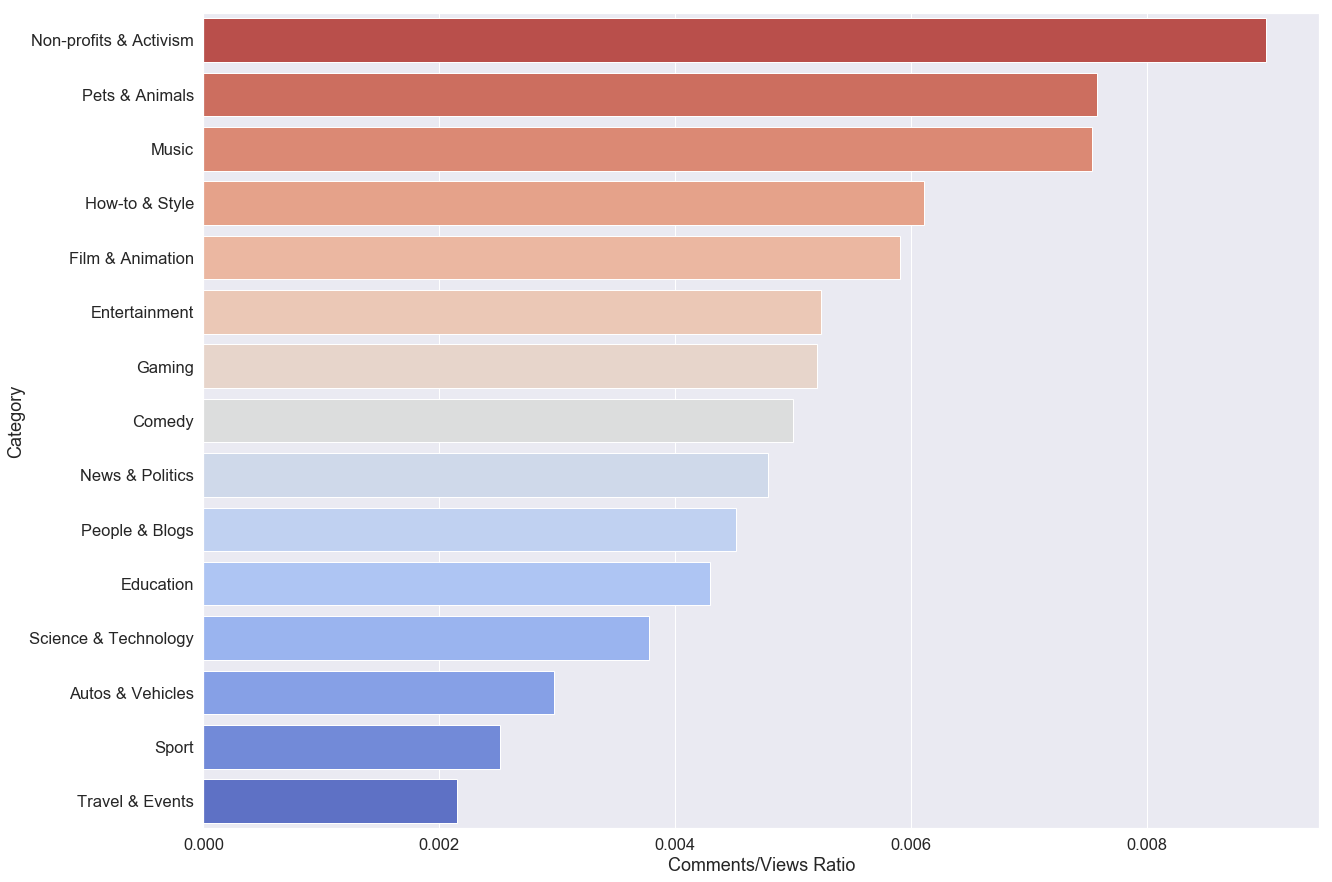

In [29]:
view_comment_ratio = videos_df.groupby('category_name')['comment_count'].sum() / videos_df.groupby('category_name')['view_count'].sum()
view_comment_ratio = view_comment_ratio.sort_values(ascending=False).reset_index()
view_comment_ratio.columns = ['category','ratio']
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='ratio', y='category', data=view_comment_ratio, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Comments/Views Ratio', ylabel='Category')

fig.savefig('plots/comment_view_ratio')

### Likes/Views ratio by category

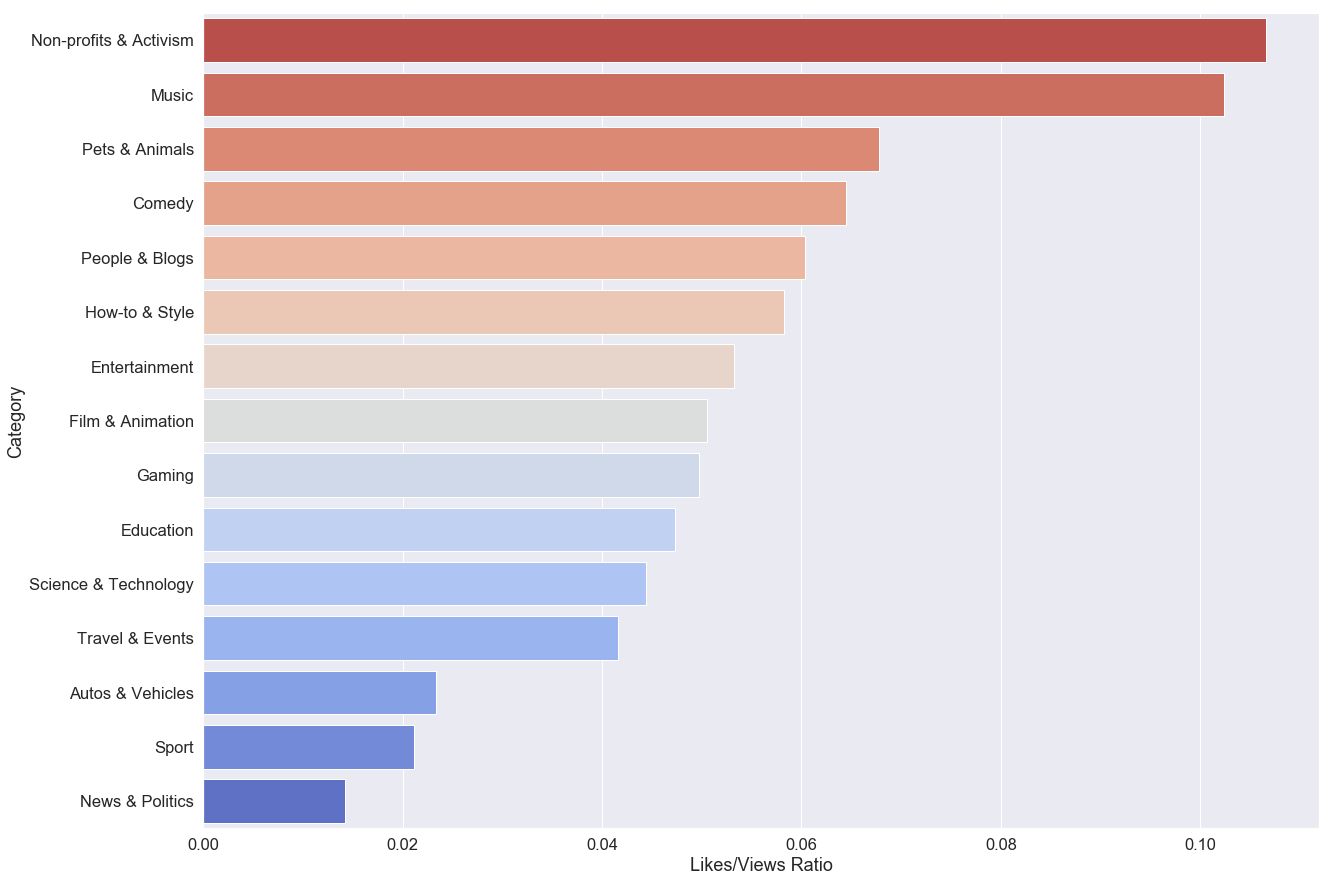

In [32]:
view_like_ratio = videos_df.groupby('category_name')['likes'].sum() / videos_df.groupby('category_name')['view_count'].sum()
view_like_ratio = view_like_ratio.sort_values(ascending=False).reset_index()
view_like_ratio.columns = ['category','ratio']
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='ratio', y='category', data=view_like_ratio, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Likes/Views Ratio', ylabel='Category')

fig.savefig('plots/like_view_ratio')

### Dislikes/Views ratio by category

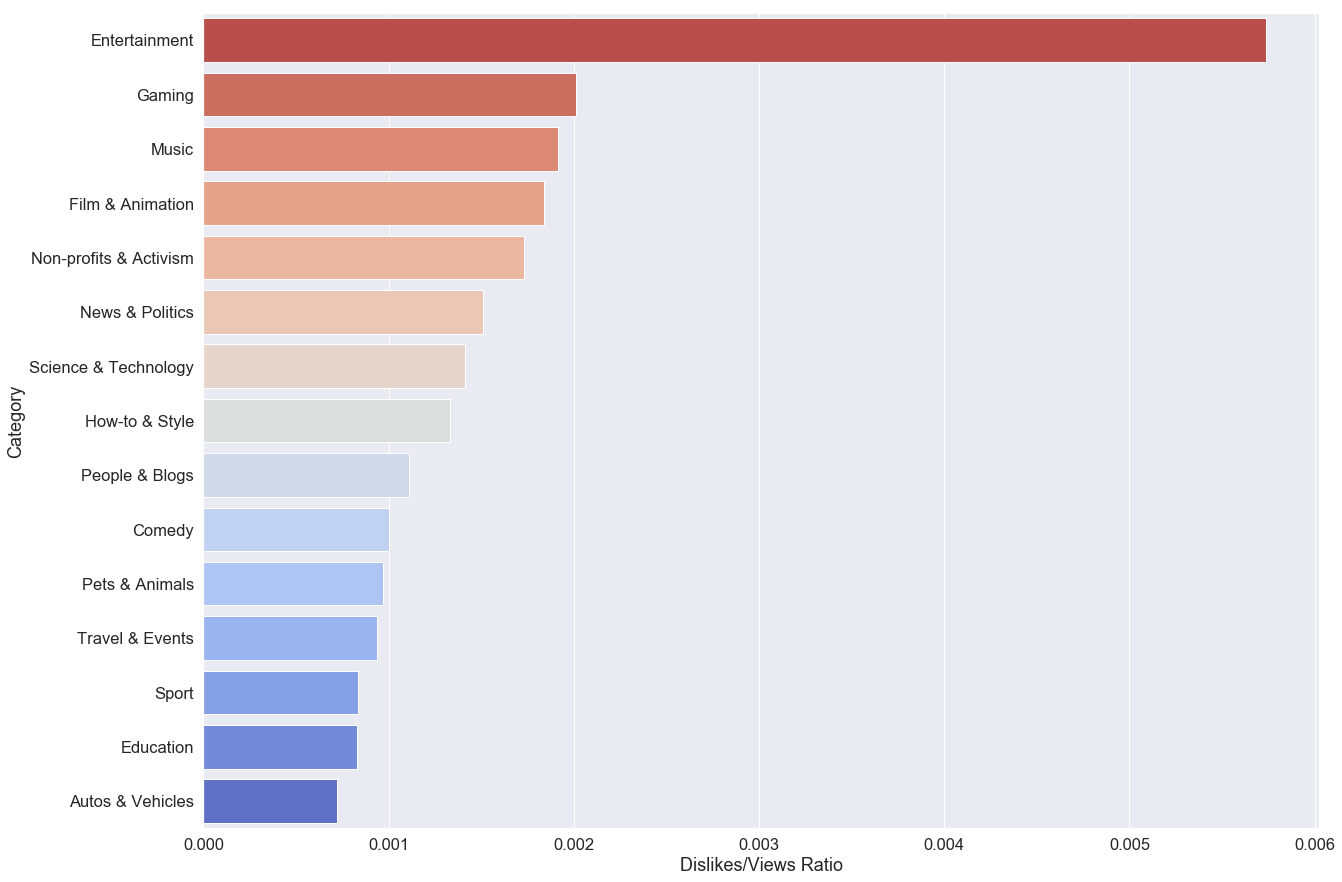

In [33]:
view_dislike_ratio = videos_df.groupby('category_name')['dislikes'].sum() / videos_df.groupby('category_name')['view_count'].sum()
view_dislike_ratio = view_dislike_ratio.sort_values(ascending=False).reset_index()
view_dislike_ratio.columns = ['category','ratio']
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='ratio', y='category', data=view_dislike_ratio, palette='coolwarm_r', ax=ax)
ax.set(xlabel='Dislikes/Views Ratio', ylabel='Category')

fig.savefig('plots/dislike_view_ratio')

### Top views videos wall

In [15]:
top_videos = videos_df.sort_values('view_count', ascending=False)
top_videos_thumbnail = top_videos['thumbnail_link'].head(100).reset_index()['thumbnail_link']
top_videos_thumbnail

0     https://i.ytimg.com/vi/2lAe1cqCOXo/default.jpg
1     https://i.ytimg.com/vi/br9Bz-x0LeQ/default.jpg
2     https://i.ytimg.com/vi/RxAtuMu_ph4/default.jpg
3     https://i.ytimg.com/vi/pILCn6VO_RU/default.jpg
4     https://i.ytimg.com/vi/gIOyB9ZXn8s/default.jpg
                           ...                      
95    https://i.ytimg.com/vi/eyzxu26-Wqk/default.jpg
96    https://i.ytimg.com/vi/6VF0GEf3S0I/default.jpg
97    https://i.ytimg.com/vi/gdrO-iU3Glg/default.jpg
98    https://i.ytimg.com/vi/fY-LA3YaZ_M/default.jpg
99    https://i.ytimg.com/vi/CPK_IdHe1Yg/default.jpg
Name: thumbnail_link, Length: 100, dtype: object

In [16]:
rows = 10
columns = 10
tempHTML = ''
innerHTML = '<div style="block">'
    
for r in range(rows):
    rowHTML = ''
    for c in range(columns):
        tempHTML = '<img src="' + top_videos_thumbnail[c*10 + r] + '"style="float:left;width:80px;height:80px;margin:0">'
        rowHTML += tempHTML
    innerHTML += rowHTML
innerHTML += '</div>'
display(HTML(innerHTML))

### Heatmap of Category vs Trending Duration ratio

Text(151.421875, 0.5, 'Category')

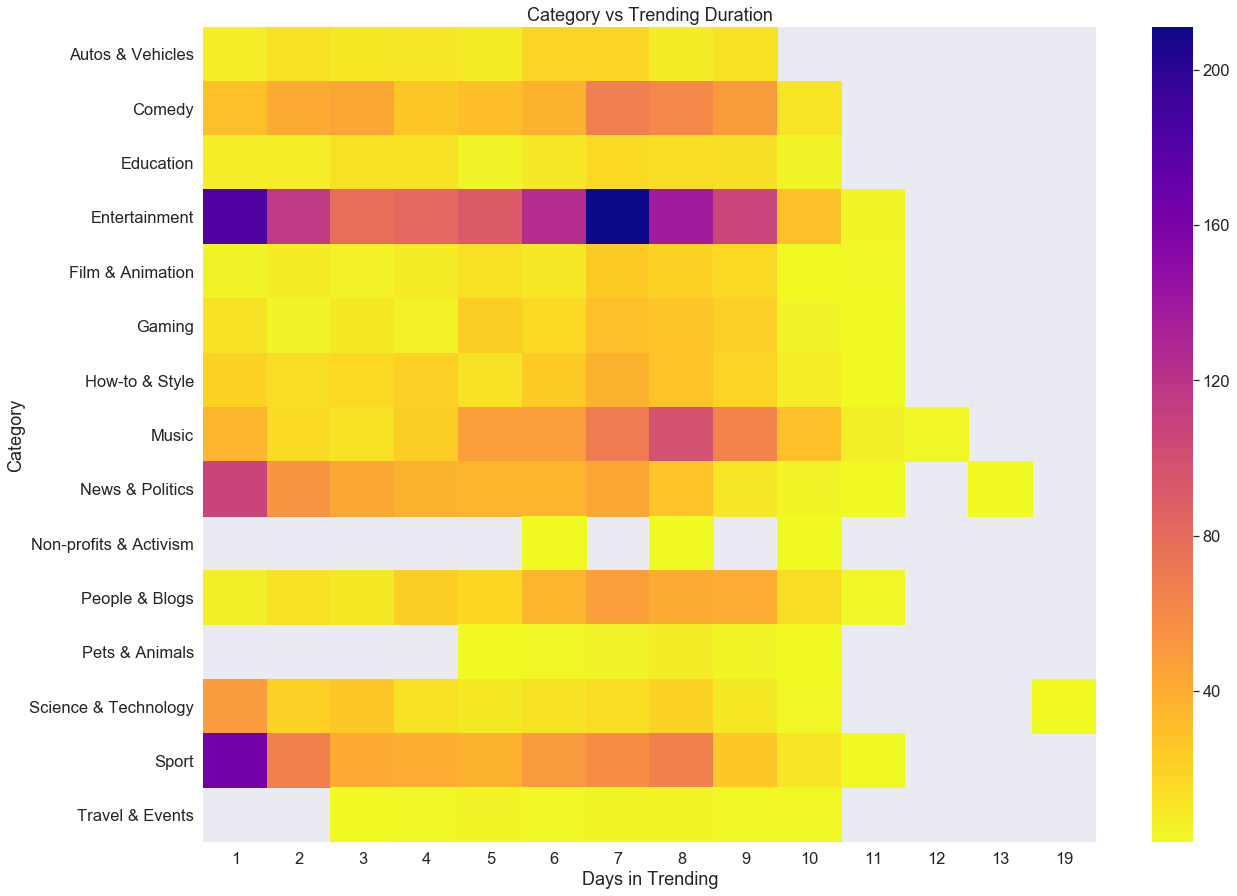

In [17]:
cat_trend_duration = videos_df.groupby(['category_name','days_in_trending']).count()['video_id'].unstack().clip(upper=300)

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cat_trend_duration, cmap='plasma_r')
plt.title("Category vs Trending Duration")
plt.xlabel('Days in Trending')
plt.ylabel('Category')

### The most popular time to upload video

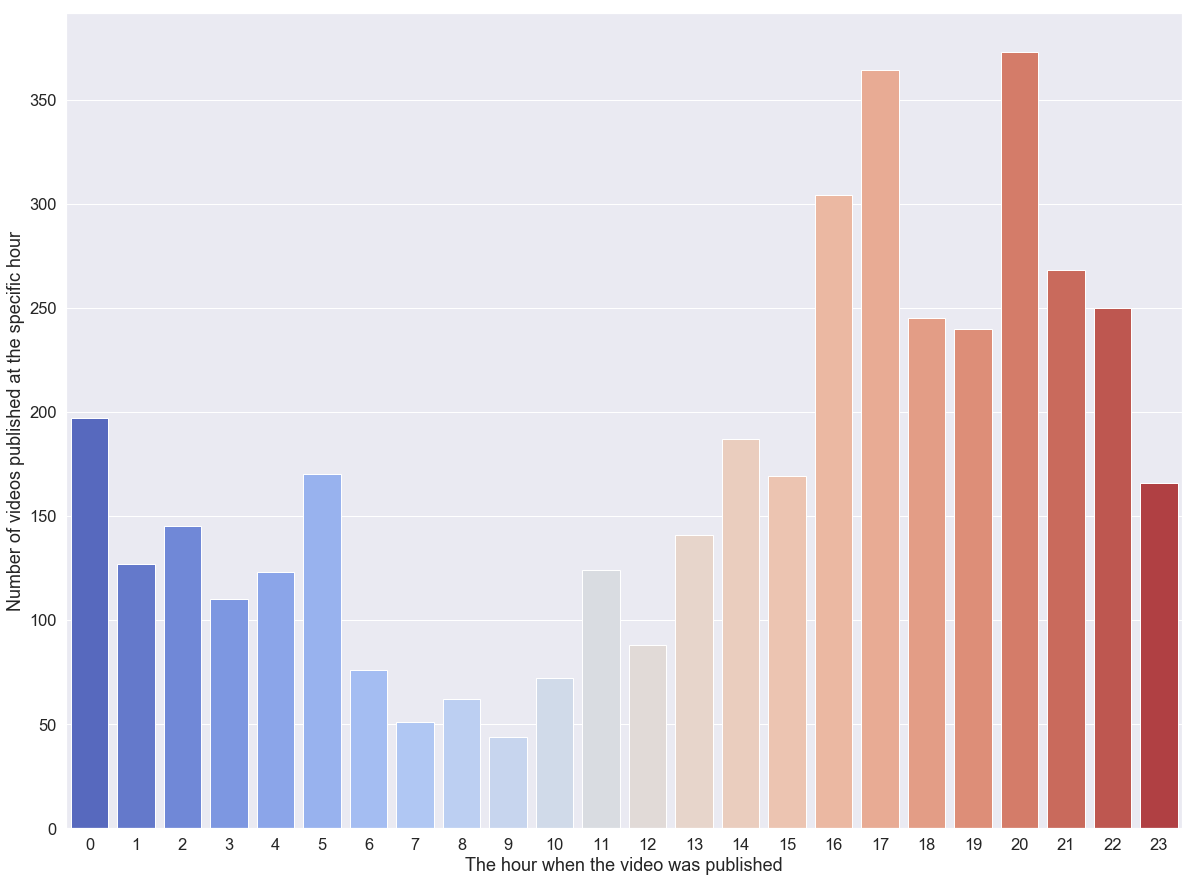

In [18]:
#most popular period of day to upload video
num_videos_in_each_hour = videos_df.groupby('publishing_hour')[['video_id', 'publishing_hour']].count()

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=num_videos_in_each_hour.index, y=num_videos_in_each_hour['video_id'], palette='coolwarm', ax=ax)
ax.set(xlabel='The hour when the video was published', ylabel='Number of videos published at the specific hour')

fig.savefig('plots/popular_upload_time')

### The most popular day of week for publishing video

[Text(0, 0.5, 'Number of videos published at the specific day in week'),
 Text(0.5, 0, 'The day in week when the video was published')]

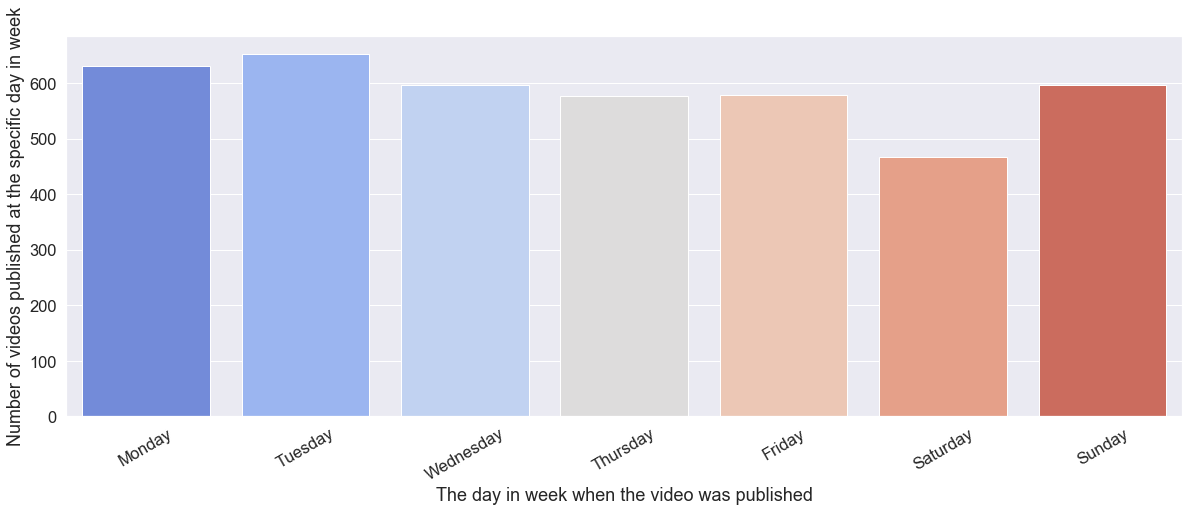

In [19]:
#most popular day to upload video

num_videos_in_each_day = videos_df.groupby('publishing_day')[['video_id', 'publishing_day']].count()
days_in_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(x='publishing_day', data=videos_df, order=days_in_week, palette='coolwarm', ax=ax)
plt.xticks(rotation=30)
ax.set(xlabel='The day in week when the video was published', ylabel='Number of videos published at the specific day in week')

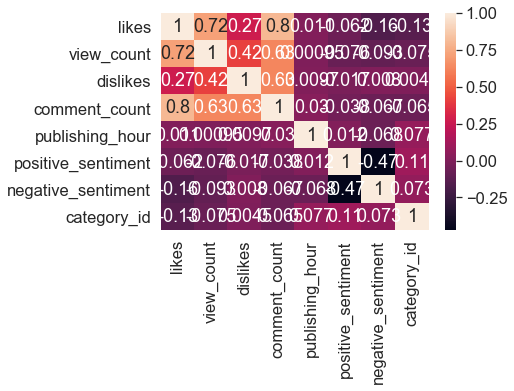

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))
features = videos_df[['likes', 'view_count', 'dislikes', 'comment_count', 'publishing_hour', 'positive_sentiment', 'negative_sentiment', 'category_id']]
sns.heatmap(features.corr(), annot=True)

### Jointplots between likes, comments, views, days in trending, days to get in trending...

C:\Users\Marko\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 0.98, 'Corellation between likes and views')

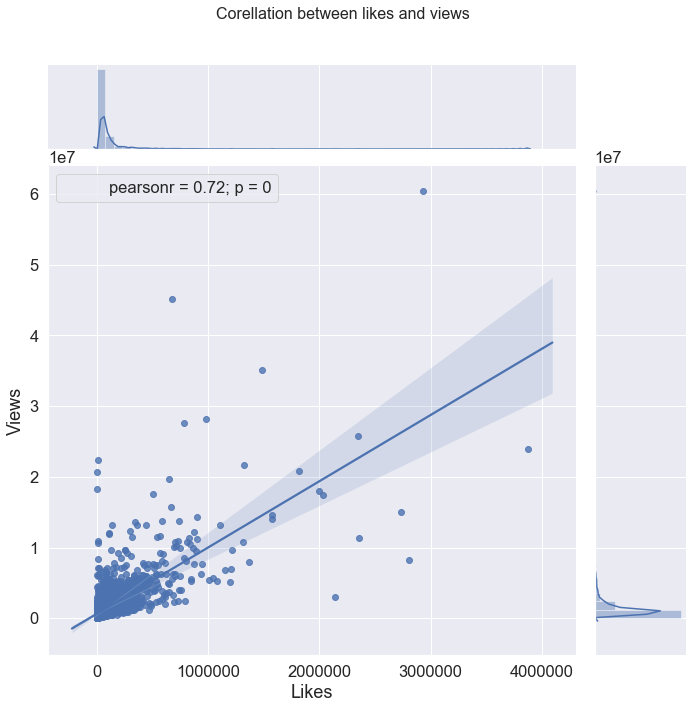

In [20]:
# Corellation between likes and views
likes_views = (sns.jointplot(data=videos_df, x='likes', y='view_count', kind='reg', height=10)
                .set_axis_labels("Likes", "Views"))
likes_views.annotate(stats.pearsonr)
likes_views.fig.subplots_adjust(top=0.9)
likes_views.fig.suptitle('Corellation between likes and views', fontsize=16)

Text(0.5, 0.98, 'Corellation between comments and views')

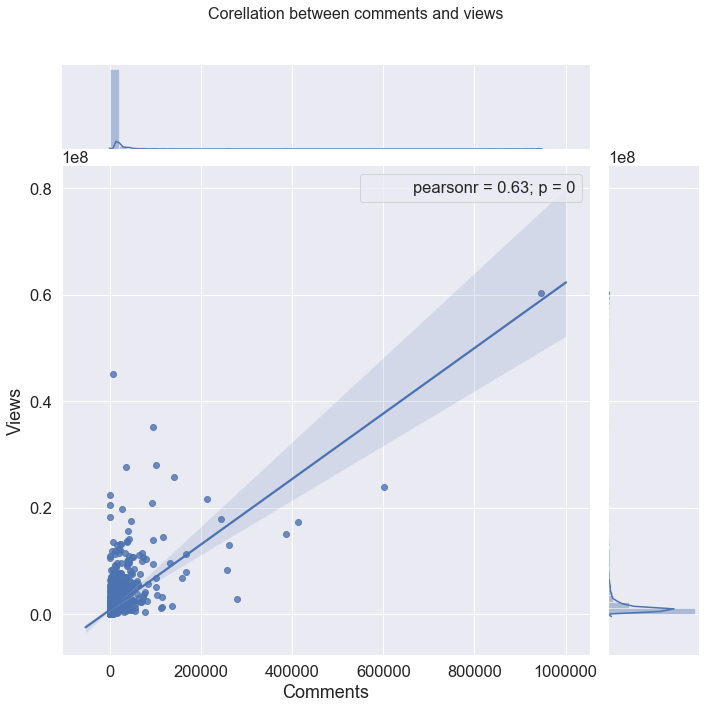

In [21]:
# Corellation between comments and views
comments_views = (sns.jointplot(data=videos_df, x='comment_count', y='view_count', kind='reg', height=10)
                .set_axis_labels("Comments", "Views"))
comments_views.annotate(stats.pearsonr)
comments_views.fig.subplots_adjust(top=0.9)
comments_views.fig.suptitle('Corellation between comments and views', fontsize=16)

Text(0.5, 0.98, 'Corellation between likes and comments')

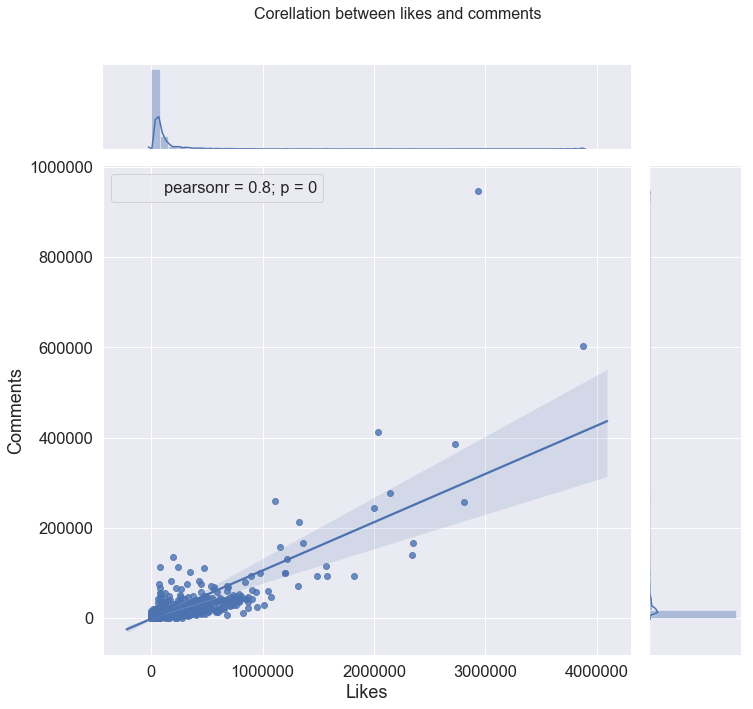

In [22]:
# Corellation between likes and comments
likes_comments = (sns.jointplot(data=videos_df, x='likes', y='comment_count', kind='reg', height=10)
                .set_axis_labels("Likes", "Comments"))
likes_comments.annotate(stats.pearsonr)
likes_comments.fig.subplots_adjust(top=0.9)
likes_comments.fig.suptitle('Corellation between likes and comments', fontsize=16)

KeyboardInterrupt: 

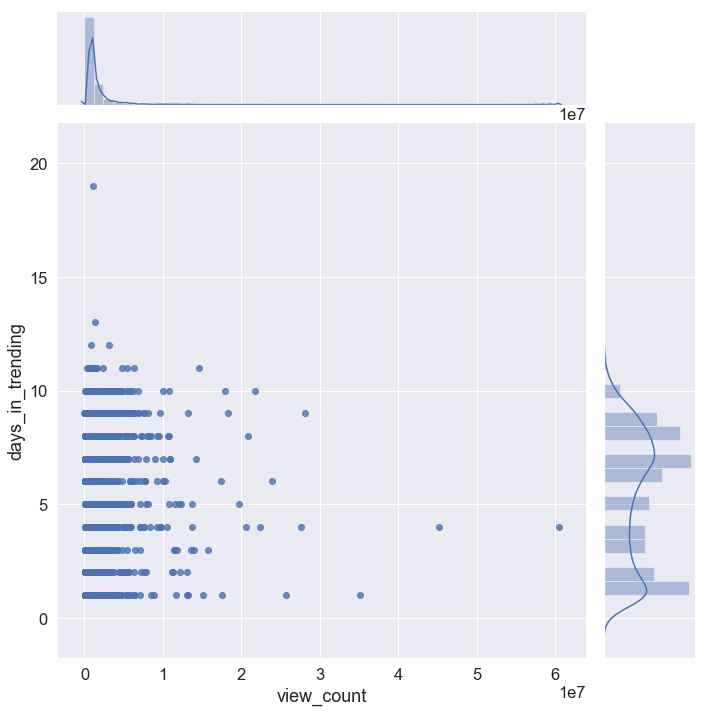

In [23]:
# Corellation between views and days in trending
views_trending = (sns.jointplot(data=videos_df, x='view_count', y='days_in_trending', kind='reg', height=10)
                .set_axis_labels("Views", "Days in trending"))
views_trending.annotate(stats.pearsonr)
views_trending.fig.subplots_adjust(top=0.9)
views_trending.fig.suptitle('Corellation between views and days in trending', fontsize=16)

# THERE ISN'T ANY CORELLATION BETWEEN VIEWS AND DAYS IN TRENDING!!!

In [ ]:
# Corellation between likes and days in trending
views_trending = (sns.jointplot(data=videos_df, x='likes', y='days_in_trending', kind='reg', height=10)
                .set_axis_labels("Likes", "Days in trending"))
views_trending.annotate(stats.pearsonr)
views_trending.fig.subplots_adjust(top=0.9)
views_trending.fig.suptitle('Corellation between likes and days in trending', fontsize=16)

# THERE ISN'T ANY CORELLATION BETWEEN LIKES AND DAYS IN TRENDING!!!

In [ ]:
# Corellation between comments and days in trending
views_trending = (sns.jointplot(data=videos_df, x='comment_count', y='days_in_trending', kind='reg', height=10)
                .set_axis_labels("Comments", "Days in trending"))
views_trending.annotate(stats.pearsonr)
views_trending.fig.subplots_adjust(top=0.9)
views_trending.fig.suptitle('Corellation between comments and days in trending', fontsize=16)

# THERE ISN'T ANY CORELLATION BETWEEN COMMENTS AND DAYS IN TRENDING!!!

In [ ]:
# Corellation between days to trend and days in trending
views_trending = (sns.jointplot(data=videos_df, x='publish_to_trend', y='days_in_trending', kind='reg', height=10)
                .set_axis_labels("Days to trend", "Days in trending"))
views_trending.annotate(stats.pearsonr)
views_trending.fig.subplots_adjust(top=0.9)
views_trending.fig.suptitle('Corellation between days to trend and days in trending', fontsize=16)

# THERE ISN'T ANY CORELLATION BETWEEN DAYS TO TREND AND DAYS IN TRENDING!!!

In [ ]:
# treba dodati celobrojnu vrednost publishing_day-a
sns.pairplot(videos_df[['view_count', 'likes', 'comment_count', 'days_in_trending', 'publish_to_trend', 'publishing_hour']], palette='coolwarm')

# IT CAN BE SEEN THAT THERE IS A CORELLATION BETWEEN VIEW_COUNT, LIKES AND COMMENT_COUNT ()